# Linear Models
In any problem, it is often useful to start by attempting the 'simplest possible solution' first. In machine learning, this is often the linear model. Linear models for prediction could be fitted by least-squares, e.g. predictive least squares (PLS), or by hypothesis of an explicit data generating process, e.g. autoregressive moving-average (ARMA) models. Our model will have the form

$$
y(t+1) = \sum_{\ell=0}^L \left( a_\ell y(t-\ell) + b_\ell^1 x_1(t-\ell) + \cdots + b_\ell^P x_P (t-\ell) \right) + \varepsilon(t)
$$

where $y$ is our target variable, $x_1,...,x_P$ are the $P$ additional predictor variables in our dataset and $\varepsilon(t)$ are random perturbations to the system.

In this module, I will consider autoregressive models applied to the bonds data set. First, let's import the data and our libraries.

In [1]:
# Import libraries
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.signal import savgol_filter
from numpy import linalg as lin
import seaborn as sns
import pandas as pd

# Import data
my_data = genfromtxt('../Data/bond.data.csv', delimiter=',',dtype='f8')
my_data = my_data[1:,1:] #Ignore the first row (headers) and the first column (junk indices)
names = ["TSY SHORT YLD","TSY LONG YLD","CORP YLD","JUNK YLD","BOND FUT VOL",
         "STK DX TOT RET","STK IDX VOL","ROW STK TOT RET","CRUDE","CRUDE VOL",
         "USD","TSY FUT NXT DAY RET"]

## Relevant Concepts
### Principal Component Analysis
When using any high-dimensional model, having many correlated features can impair the performance of the method. In the case of a linear model, if many features are linearlty dependent, then functions that treat all features at once could be accumlating unnecessary noise by adding terms from each feature. Thus, linear dimensionality reduction is often useful to improve the performance of linear models, and in this section we use principal component analysis (PCA).

Consider a dataset of samples from a multivariate Gaussian distribution. To fit a Gaussian distribution to the data, we need to find the mean vector and covariance matrix of the data. The mean can be computed in the usual way using sample means, but computation of the covariance matrix requires us to find the directions of correlations in the data set. The level sets of a Gaussian are ellipsoids, and the principal axes of the ellipsoids correspond to vectors of uncorrelated components that may provide an alternative basis for our random vectors. PCA is a method that allows us to compute these uncorrelated components, and to orthogonally project our data onto the first $k$ components that have the most significant variance in the joint distribution.

Many implementations of PCA will use the singular value decomposition (SVD), e.g. *scikit-learn*. The following derivation is from Brunton & Kutz (2017). Given a matrix $X$ whose $N$ rows are samples from our multivariate distribution, which we assume has zero-mean. The covariance matrix $C$ is given by
$$
C = \frac{1}{N-1} X^\top X
$$
The SVD of the covariance matrix may then be produced
$$
C = Q\Sigma Q^\top 
$$
since $C$ is a real symmetric positive-definite matrix. Up to sign change, the matrix $Q$ produces the orthonomal principal component basis, and the order of the singular values $\Sigma$ corresponds to the order of the eigenvaleus of the covariance matrix.

### Delay Coordinate Map
To fit an autoregressive model, we need to produce input-output pairs that will be the training data in our model. For an AR($Q$) model, we need to produce delay vectors of the form 
$$
\begin{bmatrix} y(n-1) & y(n-2) & \cdots & y(n-Q) \end{bmatrix}
$$
for each $n= Q+1, ..., N$. For a vector of features $\begin{bmatrix} y(1) & \cdots & y(N) \end{bmatrix}^\top$, we produce the matrix of all possible delay vectors by the $\text{embed}$ map:
$$
\text{embed}\left(\,\begin{bmatrix} y(1) \\ \cdots \\ y(N) \end{bmatrix}\,\right) :=
\begin{bmatrix}
y(1) & \cdots & y(Q) \\
\vdots & & \vdots \\
y(n-Q+1) & \cdots & y(n) \\
\vdots & & \vdots \\
y(N-Q+1) & \cdots & y(N)
\end{bmatrix}
$$
We may implement the embed map with a Python function:

In [2]:
def embed(x,Q,tau):
    """
    This is a simple delay embedding function. 
    
    :param x: is the input time series, arranged as a Nx1 colummn matrix (numpy array)
    :param Q: is the dimension of the desired delay coordinate matrix
    :param tau: is the time delay between entries, if needed
    :returns: The delay embedding matrix X
    """
    N = x.shape[0]
    X = np.empty((N-(Q-1)*tau,Q))
    for q in range(0,Q):
        X[:,q] = x[np.arange(0,N-(Q-1)*tau)+q*tau]
    return X

In practice, the embed map allows us to organize data to train AR and ARX models easily. We note that the embed map is also commonly used in dynamical systems theory and neuroscience, where the delay embedding map plays an important role in the reconstruction of unobserved latent state space models.

### Moving-Average Data Imputation
In this dataset, there are a few missing data points, which will be bothersome if we don't preprocess them out. For the bond dataset, I give a more detailed account of data imputation but here I will use the same technique to fix some isolated points.

In [3]:
def maimpute(my_data):
    for p in range(0,my_data.shape[1]):
        nanlist = np.argwhere(np.isnan(my_data[:,p]))
        if nanlist.size > 0:
            #Since I know that no NaN occur near n=0, I can take moving-averages without boundary conditions.
            for k in range(0,nanlist.size):
                my_data[nanlist[k],p] = np.mean(my_data[int(nanlist[k]-1):int(nanlist[k]),p])
    return my_data
        

## ARX Model
Here, we fit our ARX model for the bond data set. After visualizing the in-sample fit in this section, we will test it out of sample in the next section. For now, we will take the model order to be 5 and I'll pick it in a more principled way later.

In [4]:
# Select our training set
X = my_data[0:3000,:]

# Smooth over the outlier point
X[956,0] = 0.5*(X[955,0] + X[957,0])

# Impute missing data
X = maimpute(X)


# Deseasonalize the data
# Filter the data
window_length = 91
polyorder = 2
datatrend = savgol_filter(X, window_length, polyorder, axis=0)
X = X - datatrend

# For now, take the model length as a given
Q = 5

# Delay embed all of our data. The last column will be our target
Z = np.empty((X.shape[0]-Q+1,Q*X.shape[1]))
for k in range(0,X.shape[1]):
    Z[:,np.arange(0,Q) + k*Q] = embed(X[:,k],Q,1)

# Separate target and predictors
y = Z[:,Z.shape[1]-1]  
Z = Z[:,0:Z.shape[1]-1]

# Normalize the input predictors
Z = normalize(Z, axis=0)

Now that we have the input-output pairs for our model (in the objects `Z` and `y` respectively), we can consider PCA and fitting the model. At this point, it is instructive to visualize the correlation matrix on the delay embedding data before and after PCA.

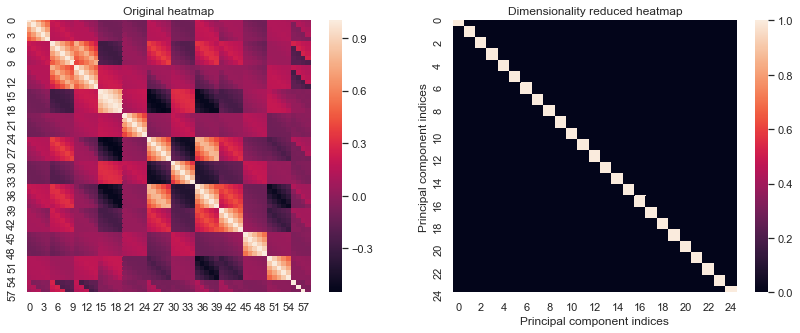

In [5]:
# Original heatmap
sns.set(rc={'figure.figsize':(14,5)})
plt.figure()
plt.subplot(1,2,1)
my_frame = pd.DataFrame(Z)
sns.heatmap(my_frame.corr())
plt.title('Original heatmap')

# Perform PCA
pca = PCA(n_components=25)
Z = pca.fit_transform(Z)

# Dimensionality reduced heatmap
plt.subplot(1,2,2)
my_frame = pd.DataFrame(Z)
sns.heatmap(my_frame.corr())
plt.title('Dimensionality reduced heatmap')
plt.xlabel('Principal component indices')
plt.ylabel('Principal component indices')
plt.show()


We observe that the dimensionality reduced heatmap is diagonal, which indicates that our PCA successfully produced uncorrelated components.

Next, we need to fit a linear model to the data. For now, I'm just going to use a least squares fit.

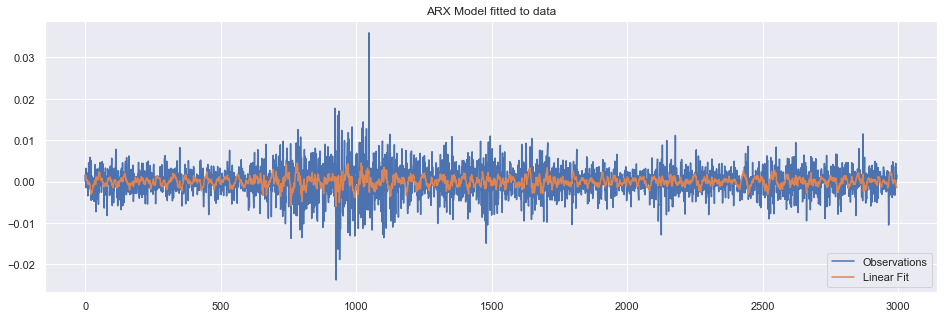

In [6]:
# Fit a linear model using least squares
linmdl = np.linalg.lstsq(Z, y, rcond=None)
yp = Z @ linmdl[0] 

# Let's plot the predictions and the results
t = np.transpose(np.arange(0,y.shape[0]))
plt.figure(figsize=(16, 5))
plt.plot(t,y,t,yp)
plt.legend(['Observations','Linear Fit'], loc='lower right')
plt.title('ARX Model fitted to data')
plt.show()

The fit isn't very good, but we can make some notes about it.

- The fit prefers to underestimate the predictions rather than propose dubious spikes oscillations. Thus, the linear fit is possibly trying to model average local behaviors.
- The predictions are point predictions that live near the mean of the process. If we consider a probabilistic forecaster, such as ARMA, we would have a chance to model our uncertainty about the process variation.
- The forecasting model is time-invariant, meaning that we are trying to model a process with stationary dynamics. It's possible that a model with time-varying dynamics could perform better here, or perhaps nonlinearity would be enough.

Another way to visualize how this model is doing is to use an observation-vs-prediction plot, shown below. We see that in this case, the prediction and observation are very circular, which indicates that our predictor is making predictions that are only somehwat correlated with the actual values. We can verify this by computing the correlation between the predictions and observations to be 0.3, which is quite low.

The correlation coefficient of predictions to observations is  0.3011809156258506


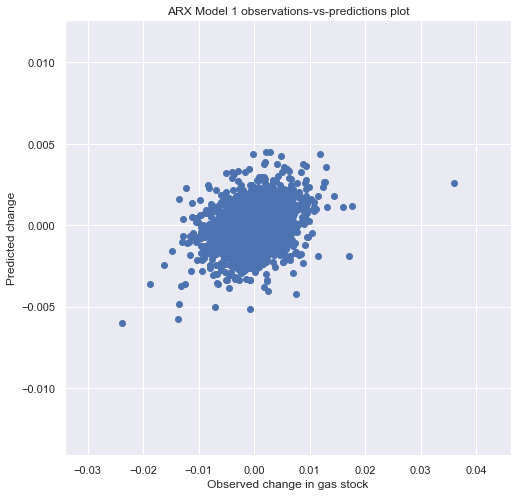

In [7]:
# Correlation coefficient
print('The correlation coefficient of predictions to observations is ',np.corrcoef(y,yp)[0,1])

# Scatterplot results
plt.figure(figsize=(8, 8))
plt.scatter(y,yp)
plt.grid('on')
plt.title('ARX Model 1 observations-vs-predictions plot')
plt.xlabel('Observed change in gas stock')
plt.ylabel('Predicted change')
plt.show()


## Out of sample fit
Let us now see how the model fits out of sample, to see if the performance is comparable to the in-sample fit. We start by processing the validation dataset.

In [8]:
# Select our validation set
X = my_data[3000:,:]

# Impute missing data
X = maimpute(X)

# Deseasonalize the data
# Filter the data
window_length = 91
polyorder = 2
datatrend = savgol_filter(X, window_length, polyorder, axis=0)
X = X - datatrend

# For now, take the model length as a given
Q = 5

# Delay embed all of our data. The last column will be our target
Z = np.empty((X.shape[0]-Q+1,Q*X.shape[1]))
for k in range(0,X.shape[1]):
    Z[:,np.arange(0,Q) + k*Q] = embed(X[:,k],Q,1)

# Separate target and predictors
y = Z[:,Z.shape[1]-1]  
Z = Z[:,0:Z.shape[1]-1]

# Normalize the input predictors
Z = normalize(Z, axis=0)

# PCA
#pca = PCA(n_components=25)
Z = pca.transform(Z)

We will now perform the prediction on the out-of-sample data.

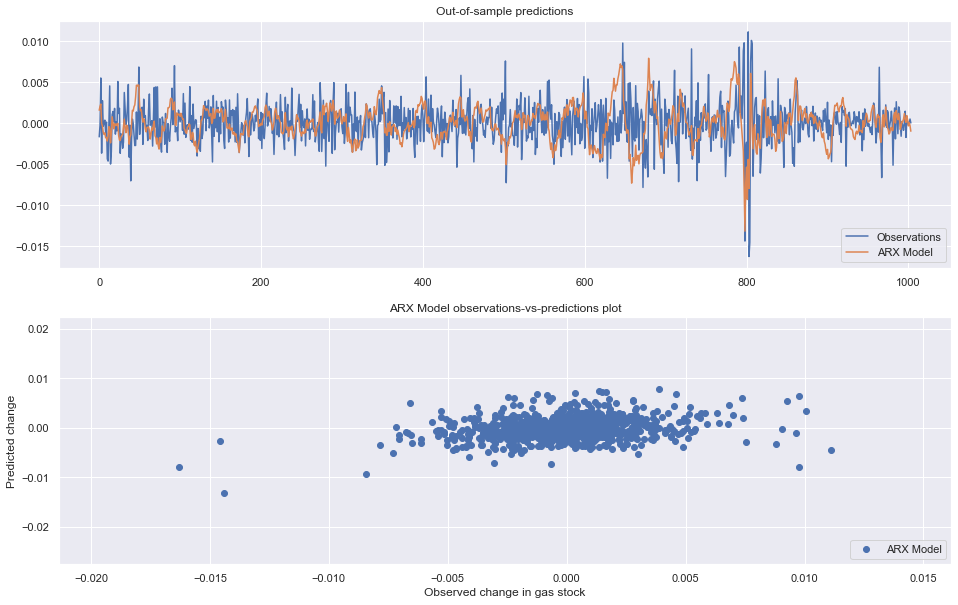

The correlation coefficient of predictions to observations is  0.2728470167355955


In [9]:
# Make predictions
yp = Z @ linmdl[0] 

# Let's plot the predictions and the results
t = np.transpose(np.arange(0,y.shape[0]))
plt.figure(figsize=(16, 10))
plt.subplot(2,1,1)
plt.plot(t,y,t,yp)
plt.legend(['Observations','ARX Model'], loc='lower right')
plt.title('Out-of-sample predictions')


# Scatterplot results
plt.subplot(2,1,2)
plt.scatter(y,yp)
plt.grid('on')
plt.title('ARX Model observations-vs-predictions plot')
plt.xlabel('Observed change in gas stock')
plt.ylabel('Predicted change')
plt.legend(['ARX Model'], loc='lower right')
plt.show()

# Correlation coefficient
print('The correlation coefficient of predictions to observations is ',np.corrcoef(y,yp)[0,1])


We see that the out-of-sample fit is not much better, but there are some qualitative differences. The out of sample preditions vary more wildly, incidating that the model was fit to be more tame for the in-sample predictions. One interesting feature is that the model detected the large oscillations near 800, but it did not model these well.

In the observations-vs-predictions plot, we see a flat distribution, indicating that the predictions are weakly coupled to the observations, and unpredict them quite often. This is reflected by the correlation between the observations and predictions, which is not only small, but also negative, indicating that the predictions may often have *negative* sign. Yikes!